# Lista 3
## zadanie 1

In [4]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, random, seaborn as sns
from scipy.stats import t, norm

In [5]:
beta_1 = 4
beta_0 = 2
alphas = [0.01, 0.05]
sigmas = [0.01, 0.5, 1]
mi = 0
n = 1000
MC = 1000

In [6]:
def b1_emp(x,y):
    return np.sum((x - np.mean(x)) * (y))/np.sum((x-np.mean(x))**2)

def b0_emp(x,y):
    return np.mean(y) - b1_emp(x,y) * np.mean(x)

In [4]:
def a(X, b0_hat, alpha, sigma):
  n = len(X)
  x_mean = np.mean(X)
  return b0_hat - norm.ppf(1-alpha/2) * sigma * np.sqrt(1/n + x_mean**2/sum((X - x_mean)**2))

def b(X, b0_hat, alpha, sigma):
  n = len(X)
  x_mean = np.mean(X)
  return b0_hat + norm.ppf(1-alpha/2) * sigma * np.sqrt(1/n + x_mean**2/sum((X - x_mean)**2))
def c(X, b1_hat, alpha, sigma):
  n = len(X)
  x_mean = np.mean(X)
  return b1_hat - norm.ppf(1-alpha/2) * sigma * np.sqrt(1/sum((X - x_mean)**2))

def d(X, b1_hat, alpha, sigma):
  n = len(X)
  x_mean = np.mean(X)
  return b1_hat + norm.ppf(1-alpha/2) * sigma * np.sqrt(1/sum((X - x_mean)**2))

In [13]:
def abcd_n(X, b0_hat, b1_hat, alpha, sigma):
  n = len(X)
  x_mean = np.mean(X)
  n1 = norm.ppf(1-alpha/2)
  b0_part = n1 * sigma * np.sqrt(1/n + x_mean**2/sum((X - x_mean)**2))
  b1_part = n1 * sigma * np.sqrt(1/sum((X - x_mean)**2))
  a = b0_hat - b0_part
  b = b0_hat + b0_part
  c = b1_hat - b1_part
  d = b1_hat + b1_part
  return a, b, c, d

In [15]:
def prob(n, mc, beta_0, beta_1, sigma, alpha):
  X = np.arange(0, n) +1
  b0_prob = 0
  b1_prob = 0
  for i in range(mc):
    e = np.random.normal(0, sigma, size = n)
    Y = beta_0 + beta_1*X + e
    b0_hat = b0_emp(X, Y)
    b1_hat = b1_emp(X, Y)
    a, b, c, d = abcd_n(X, b0_hat, b1_hat, alpha, sigma)
    if (a<= beta_0) & (beta_0 <= b):
      b0_prob += 1
    if (c<= beta_1) & (beta_1 <= d):
      b1_prob += 1
  b0_prob = b0_prob/mc
  b1_prob = b1_prob/mc
  return b0_prob, b1_prob

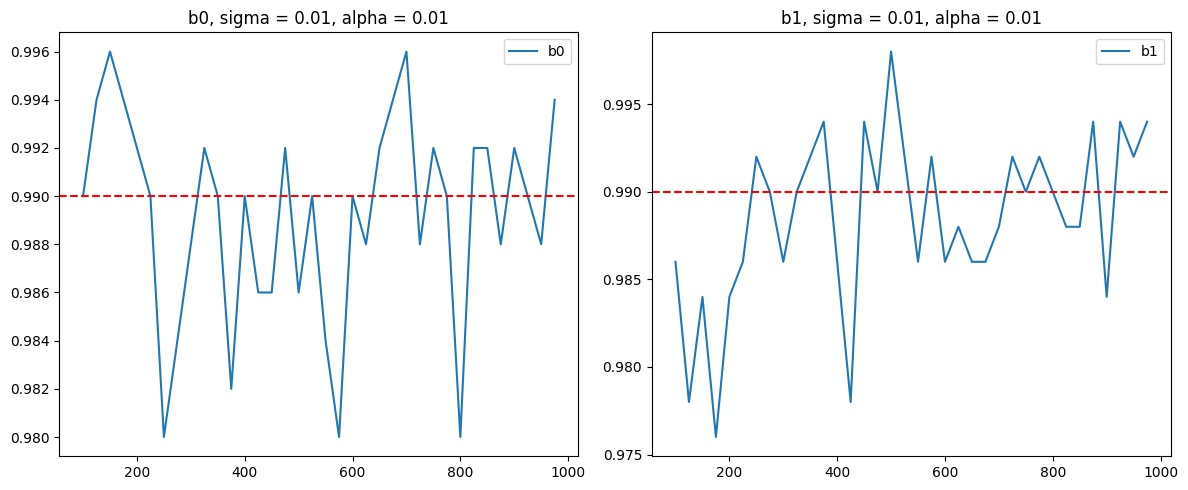

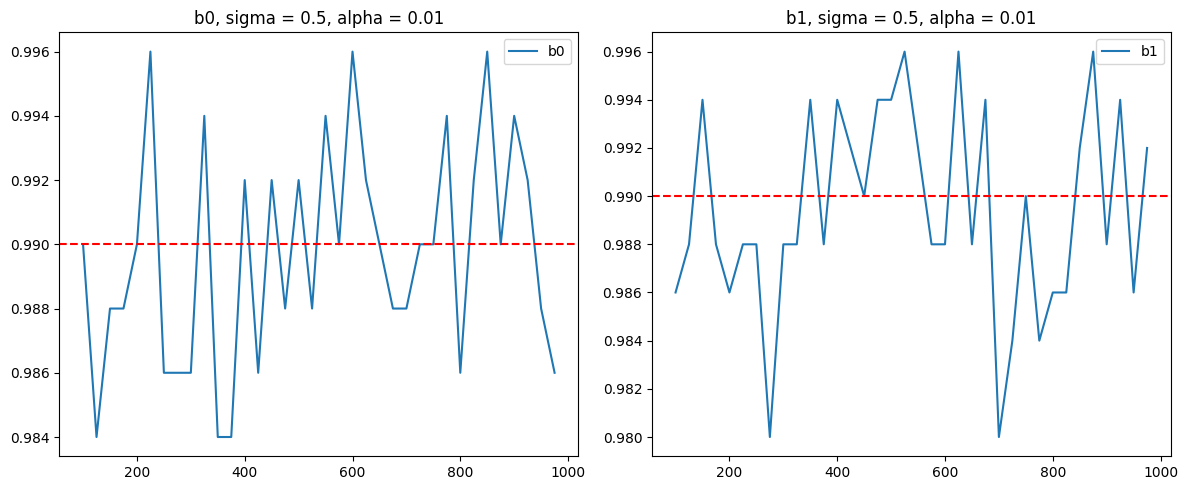

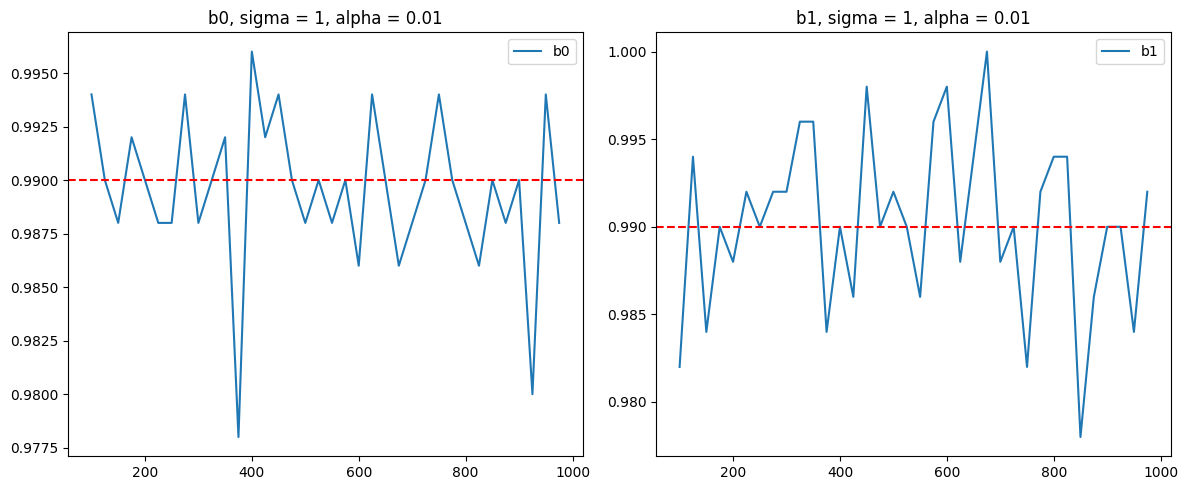

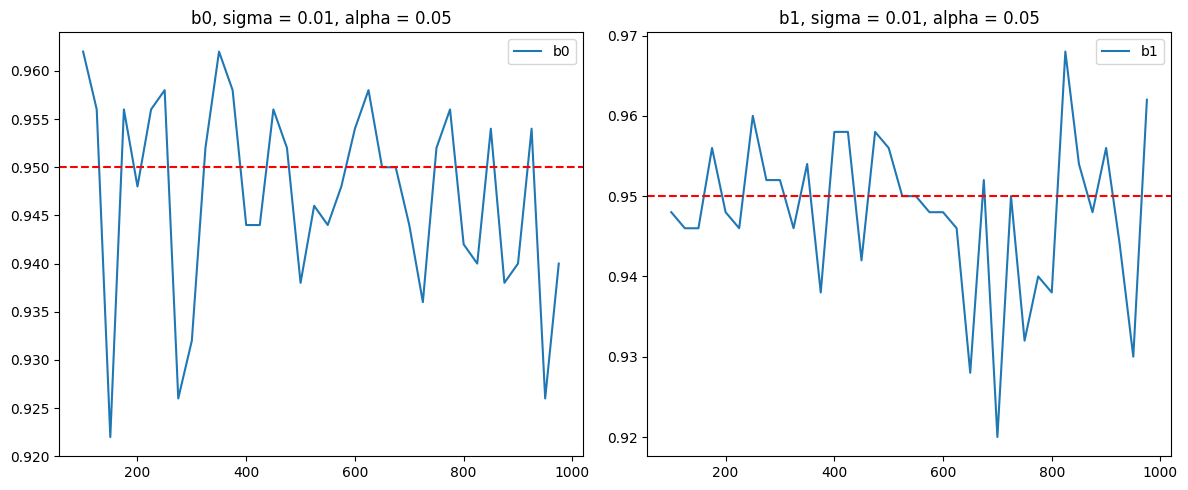

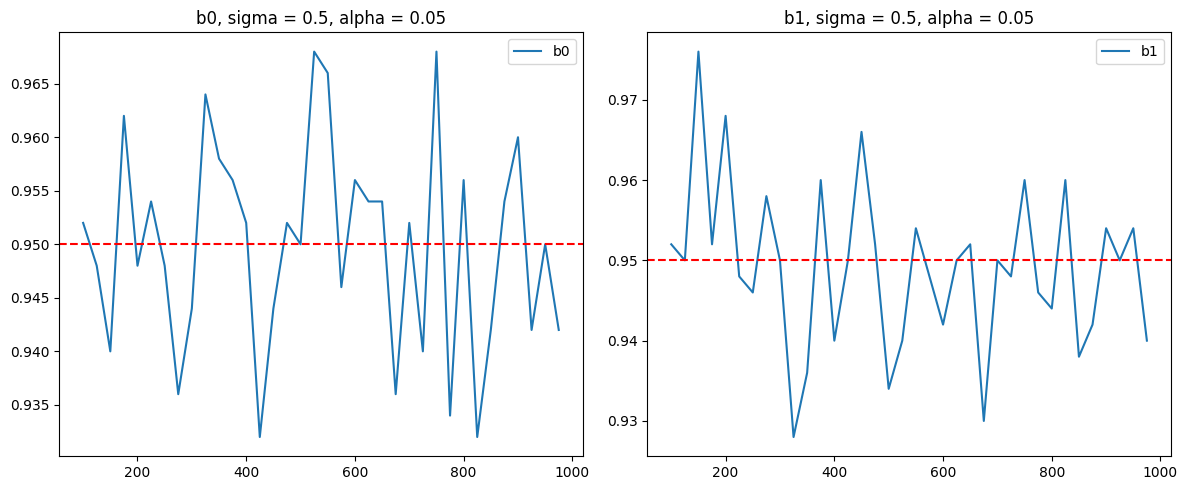

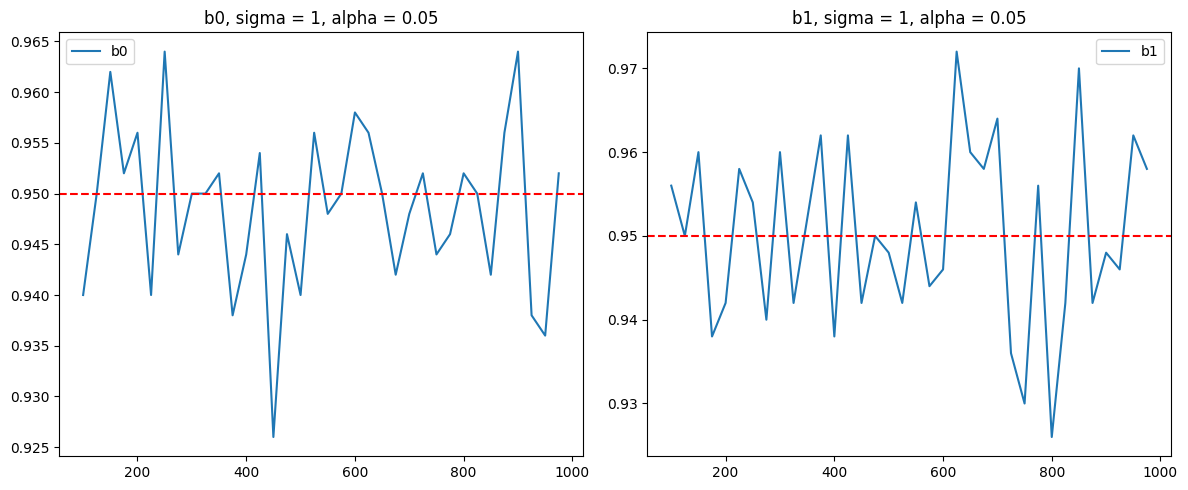

In [16]:
xs  = range(100, 1000, 25)
MC = 500
for alpha in alphas:
  for sigma in sigmas:
    prob_b0= [prob(i, MC, beta_0, beta_1, sigma, alpha)[0] for i in xs]
    prob_b1= [prob(i, MC, beta_0, beta_1, sigma, alpha)[1] for i in xs]

    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    axes[0].plot(xs, prob_b0, label='b0')
    axes[0].axhline(y=1 - alpha, color='red', linestyle='--')
    axes[0].set_title(f'b0, sigma = {sigma}, alpha = {alpha}')
    axes[0].legend()

    axes[1].plot(xs, prob_b1, label='b1')
    axes[1].axhline(y=1 - alpha, color='red', linestyle='--')
    axes[1].set_title(f'b1, sigma = {sigma}, alpha = {alpha}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## dygresja

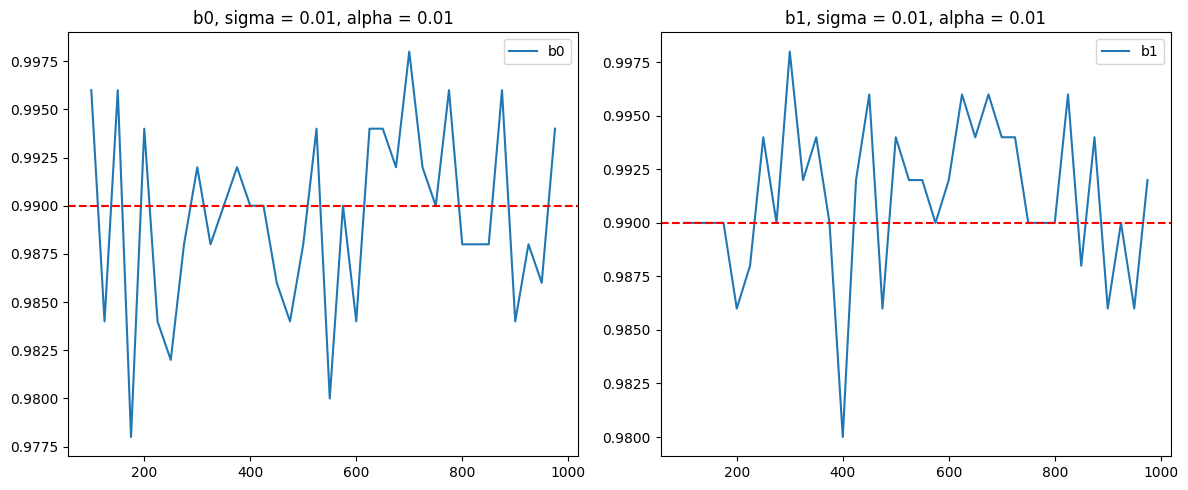

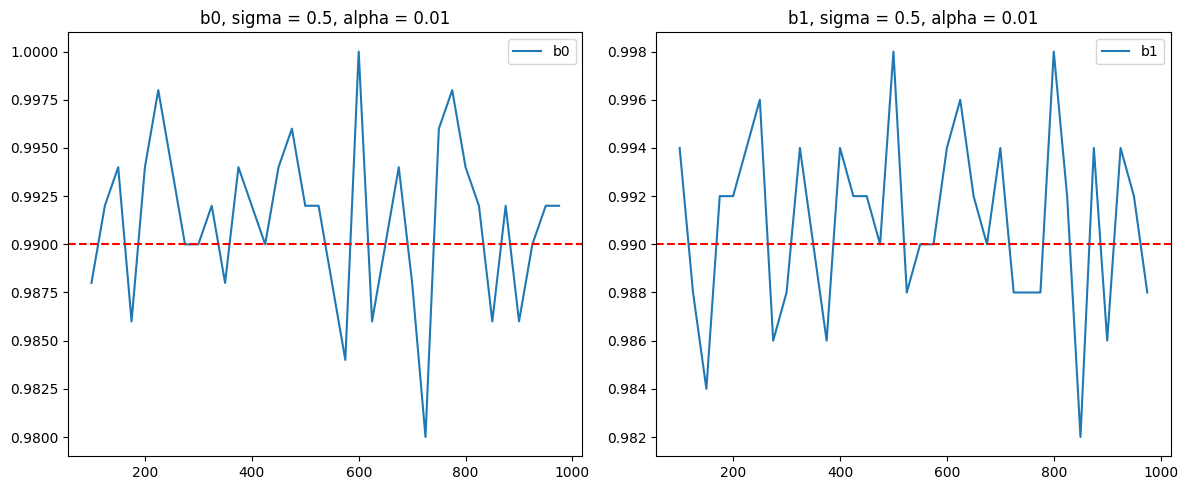

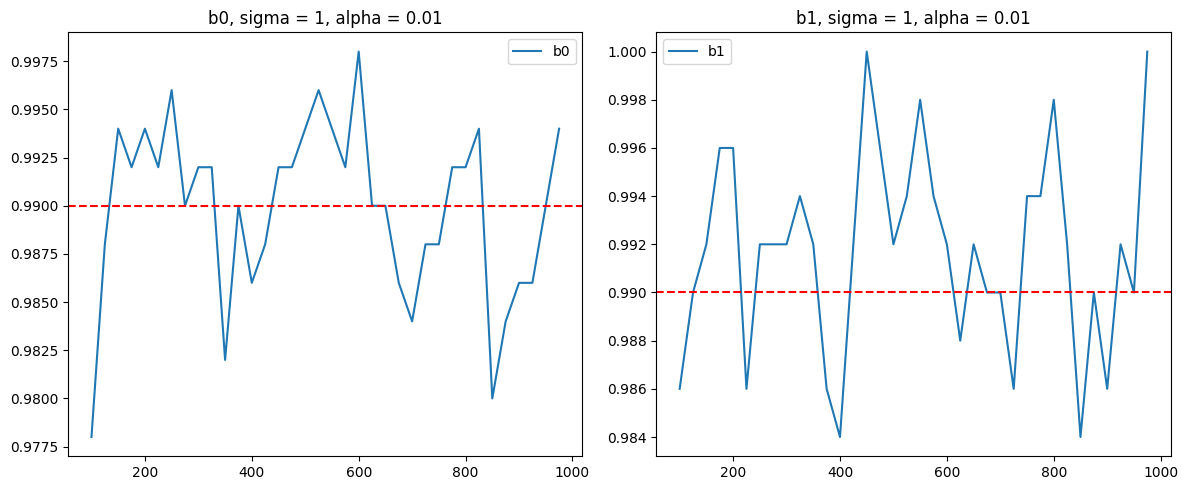

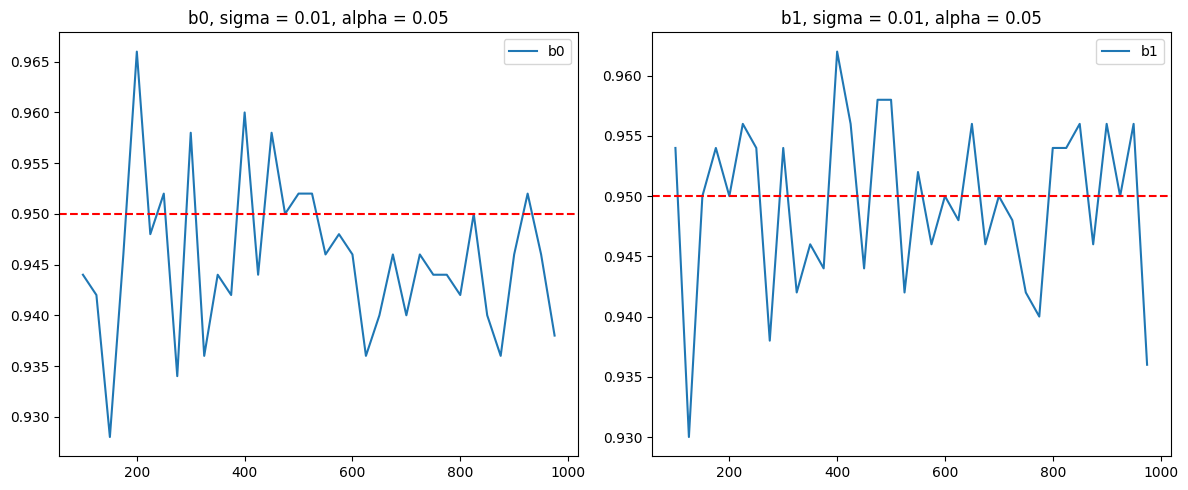

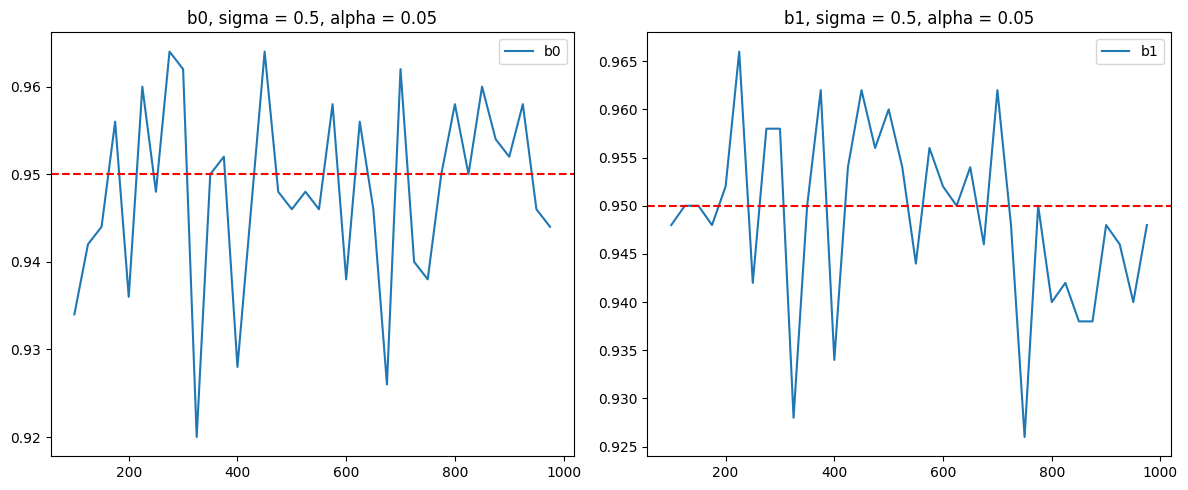

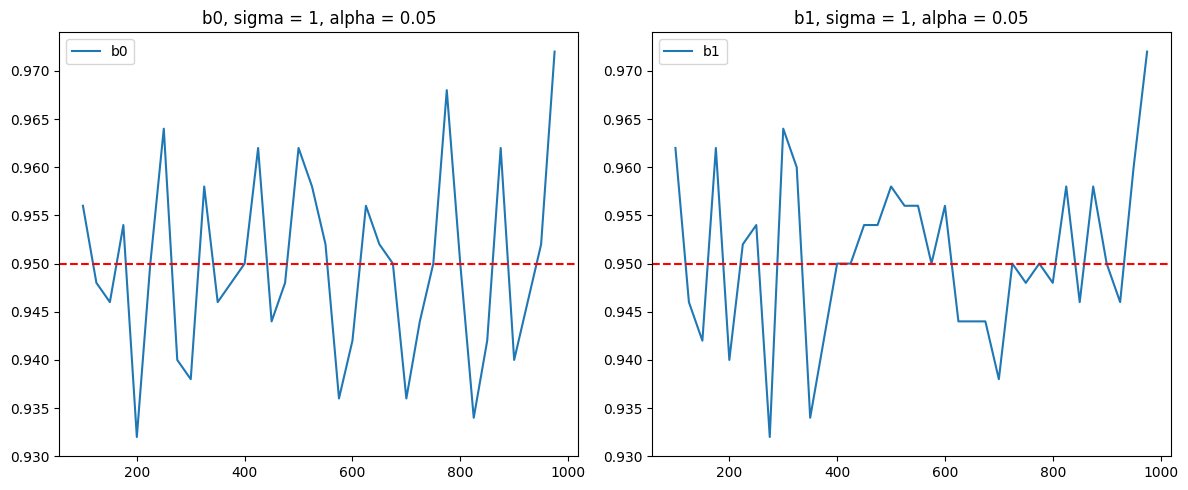

In [10]:
# szybsza wersja
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import Parallel, delayed

# Data setup
beta_1 = 4
beta_0 = 2
alphas = [0.01, 0.05]
sigmas = [0.01, 0.5, 1]
n = 1000
MC = 500

# Empirical estimates for beta_1 and beta_0
def b1_emp(x, y):
    return np.sum((x - np.mean(x)) * y) / np.sum((x - np.mean(x))**2)

def b0_emp(x, y):
    return np.mean(y) - b1_emp(x, y) * np.mean(x)

# Interval functions optimized by precomputing common terms
def interval_bounds(X, b0_hat, b1_hat, alpha, sigma):
    n = len(X)
    x_mean = np.mean(X)
    s_xx = np.sum((X - x_mean)**2)
    z_alpha = norm.ppf(1 - alpha / 2)
    
    b0_margin = z_alpha * sigma * np.sqrt(1/n + x_mean**2 / s_xx)
    b1_margin = z_alpha * sigma / np.sqrt(s_xx)
    
    a = b0_hat - b0_margin
    b = b0_hat + b0_margin
    c = b1_hat - b1_margin
    d = b1_hat + b1_margin
    return a, b, c, d

# Probability function optimized for speed
def prob(n, mc, beta_0, beta_1, sigma, alpha):
    X = np.arange(1, n + 1)
    b0_prob = 0
    b1_prob = 0
    
    for _ in range(mc):
        e = np.random.normal(0, sigma, size=n)
        Y = beta_0 + beta_1 * X + e
        b0_hat = b0_emp(X, Y)
        b1_hat = b1_emp(X, Y)
        
        a, b, c, d = interval_bounds(X, b0_hat, b1_hat, alpha, sigma)
        
        if a <= beta_0 <= b:
            b0_prob += 1
        if c <= beta_1 <= d:
            b1_prob += 1

    return b0_prob / mc, b1_prob / mc

# Parallelize the calculation over xs
def calculate_probabilities(xs, MC, beta_0, beta_1, sigma, alpha):
    return Parallel(n_jobs=-1)(delayed(prob)(i, MC, beta_0, beta_1, sigma, alpha) for i in xs)

# Plotting results for different alphas and sigmas
xs = range(100, 1000, 25)
for alpha in alphas:
    for sigma in sigmas:
        results = calculate_probabilities(xs, MC, beta_0, beta_1, sigma, alpha)
        prob_b0 = [res[0] for res in results]
        prob_b1 = [res[1] for res in results]

        fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
        axes[0].plot(xs, prob_b0, label='b0')
        axes[0].axhline(y=1 - alpha, color='red', linestyle='--')
        axes[0].set_title(f'b0, sigma = {sigma}, alpha = {alpha}')
        axes[0].legend()

        axes[1].plot(xs, prob_b1, label='b1')
        axes[1].axhline(y=1 - alpha, color='red', linestyle='--')
        axes[1].set_title(f'b1, sigma = {sigma}, alpha = {alpha}')
        axes[1].legend()

        plt.tight_layout()
        plt.show()


## zadanie 2

In [20]:
def abcd_t(X, Y, Y_hat, b0_hat, b1_hat, alpha):
  n = len(X)
  x_mean = np.mean(X)
  t1 = t.ppf(1-alpha/2, n-2)
  s2 = np.sum((Y - Y_hat)**2)/(n-2)
  s = np.sqrt(s2)
  b0_part = t1 * s * np.sqrt(1/n + x_mean**2/sum((X - x_mean)**2))
  b1_part = t1 * s * np.sqrt(1/sum((X - x_mean)**2))
  a = b0_hat - b0_part
  b = b0_hat + b0_part
  c = b1_hat - b1_part
  d = b1_hat + b1_part
  return a, b, c, d

In [22]:
def prob_t(n, mc, beta_0, beta_1, sigma, alpha):
  X = np.arange(0, n) +1
  b0_prob = 0
  b1_prob = 0
  for i in range(mc):
    e = np.random.normal(0, sigma, size = n)
    Y_hat = beta_0 + beta_1*X
    Y = Y_hat + e
    b0_hat = b0_emp(X, Y)
    b1_hat = b1_emp(X, Y)
    a, b, c, d = abcd_t(X, Y, Y_hat, b0_hat, b1_hat, alpha)
    if (a<= beta_0) & (beta_0 <= b):
      b0_prob += 1
    if (c<= beta_1) & (beta_1 <= d):
      b1_prob += 1
  b0_prob = b0_prob/mc
  b1_prob = b1_prob/mc
  return b0_prob, b1_prob

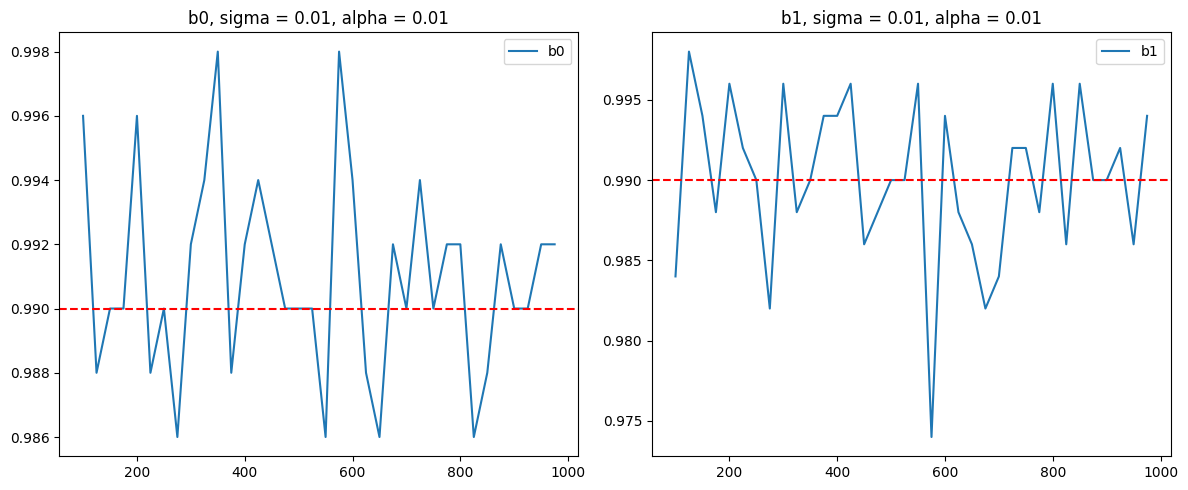

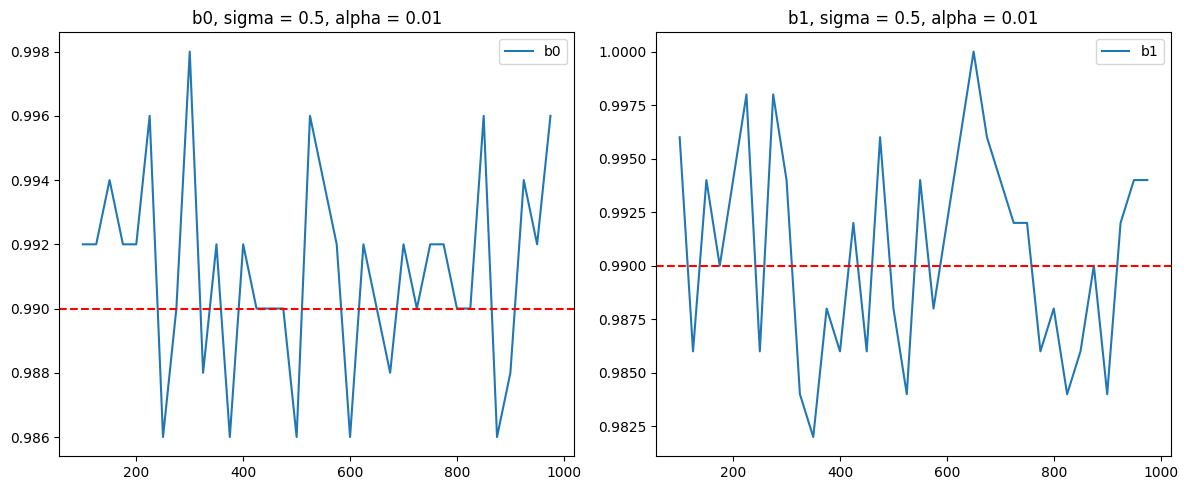

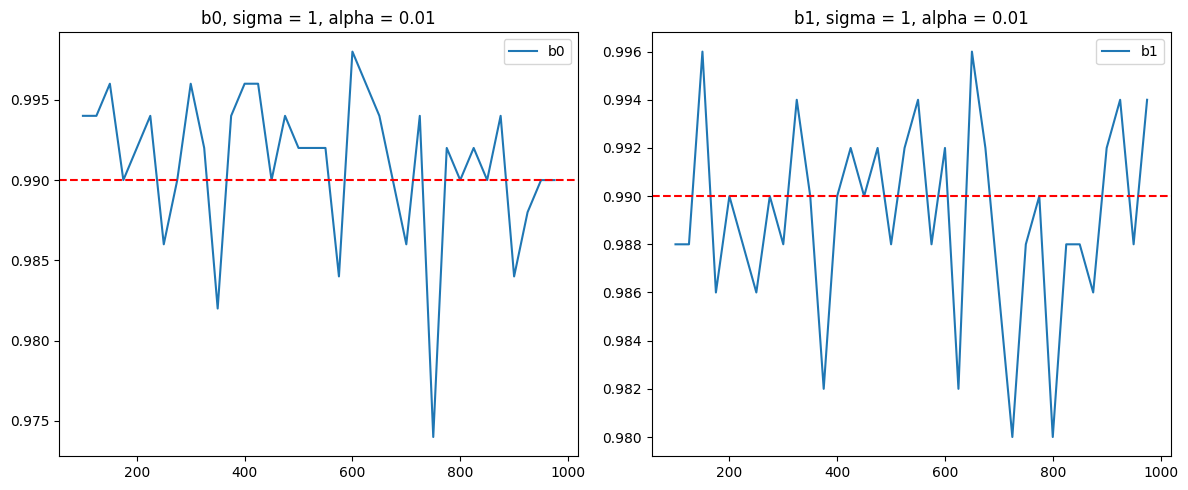

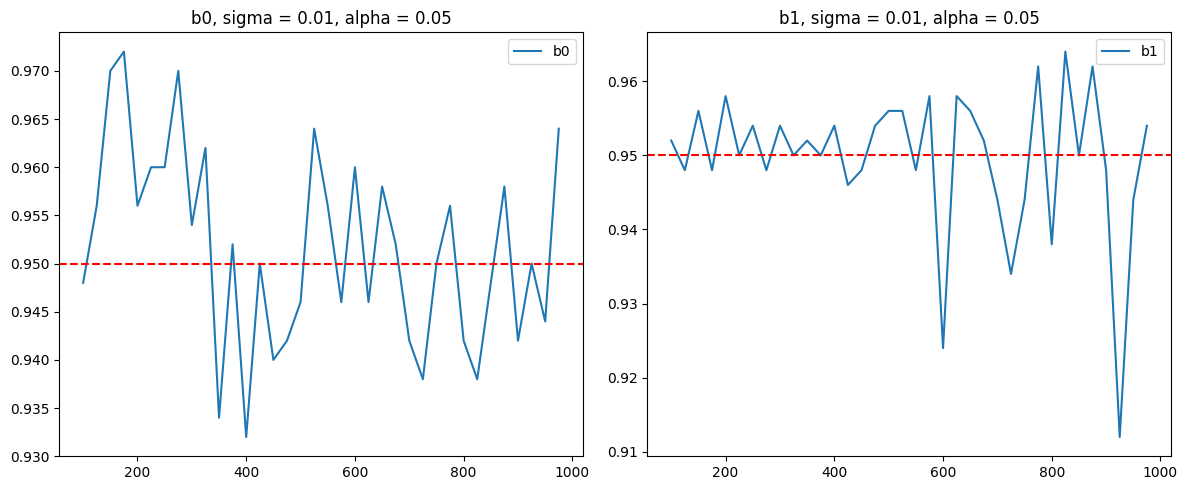

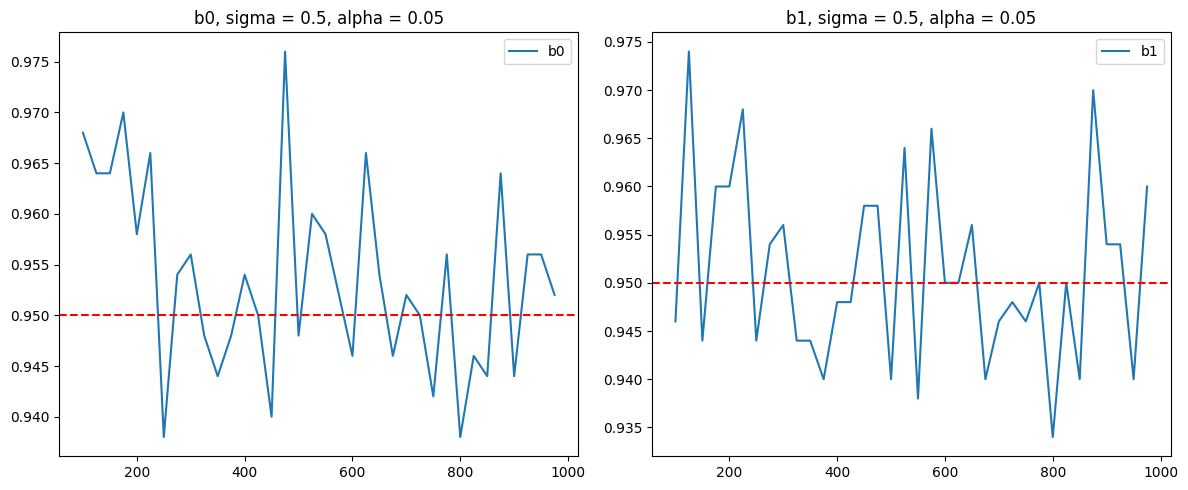

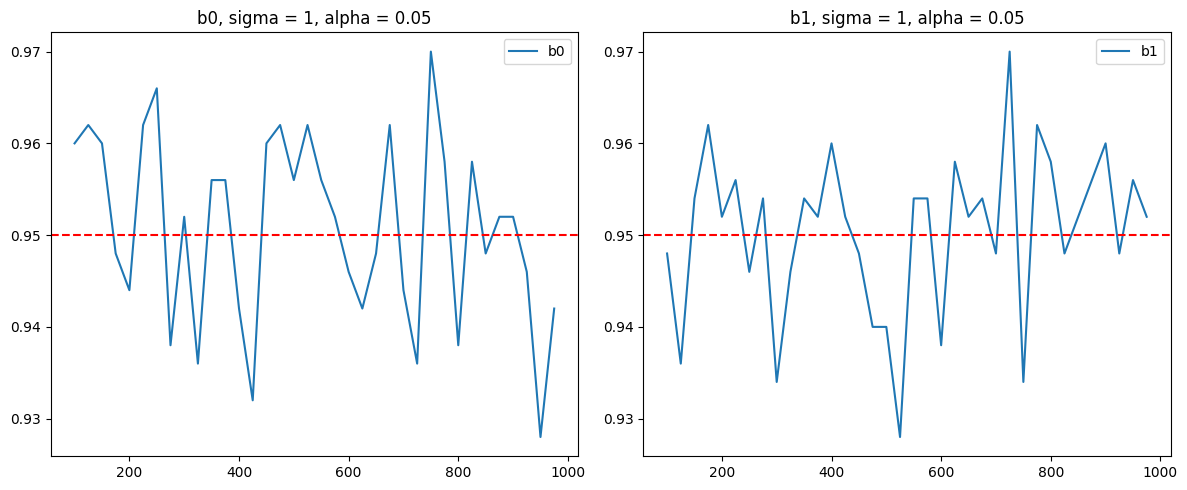

In [23]:
xs  = range(100, 1000, 25)
MC = 500
for alpha in alphas:
  for sigma in sigmas:
    prob_b0= [prob_t(i, MC, beta_0, beta_1, sigma, alpha)[0] for i in xs]
    prob_b1= [prob_t(i, MC, beta_0, beta_1, sigma, alpha)[1] for i in xs]

    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    axes[0].plot(xs, prob_b0, label='b0')
    axes[0].axhline(y=1 - alpha, color='red', linestyle='--')
    axes[0].set_title(f'b0, sigma = {sigma}, alpha = {alpha}')
    axes[0].legend()

    axes[1].plot(xs, prob_b1, label='b1')
    axes[1].axhline(y=1 - alpha, color='red', linestyle='--')
    axes[1].set_title(f'b1, sigma = {sigma}, alpha = {alpha}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()